In [35]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
torch.manual_seed(42)
import tsensor
# Get rid of findfont: Font family 'Arial' not found.
# when running a remote notebook on Jupyter Server on Ubuntu Linux server
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

from lolviz import *


mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Foundations Version

### Basic Architecture

- Assign the number of items in our training set to `n`
- Assign the number of pixels in each item to `m`
- Assign possible values of digits to `c`

In [24]:
n,m = x_train.shape
c = y_valid.max() + 1
n,m,c

(50000, 784, tensor(10))

- Assign to `nh` an integer for our 50 hidden layers, aka our 50 activation functinons, in this case *relus*

In [25]:
nh = 50

- Create the weight matrices for multiplication. 
    - The first set of weights, `w1` will be for our training set
    - The weights will also need a bias, `b1` that will begin as zeros 
    - The second set of weights, `w2` will be for our output matrix, which will just  be one output, which the guess of what number it is
    - The second bias `b2` be initialized as zeros and match `w2`

In [26]:
w1 = torch.randn(m, nh)

In [27]:
b1 = torch.zeros(nh)

In [28]:
w2 = torch.randn(nh,1)

In [29]:
b2 = torch.zeros(1)

***

In [30]:
w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([784, 50]), torch.Size([50]), torch.Size([50, 1]), torch.Size([1]))

In [31]:
(x_valid@w1 + b1).shape

torch.Size([10000, 50])

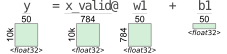

In [34]:
with tsensor.explain():
    y = x_valid@w1 + b1

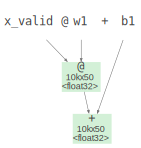

In [33]:
tsensor.astviz("x_valid@w1 + b1")

In [44]:
w1

tensor([[ 1.93,  1.49,  0.90,  ..., -0.49, -0.91, -0.66],
        [ 0.08,  0.53, -0.49,  ...,  0.49,  0.78,  0.03],
        [ 0.64,  0.58,  1.07,  ...,  1.45,  0.27, -0.21],
        ...,
        [-1.09,  0.58,  1.08,  ..., -0.04,  0.36, -0.02],
        [-0.74, -0.13, -1.27,  ..., -0.27,  0.37,  0.27],
        [ 0.46, -0.78,  2.44,  ..., -1.60, -0.04, -1.25]])

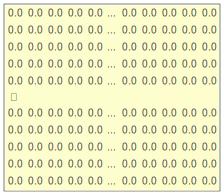

In [43]:
matrixviz(x_valid.cpu().detach().numpy())

In [10]:
(((x_valid@w1 + b1).clamp_min(0.))@w2 + b2).shape 

torch.Size([10000, 1])

In [11]:
((((x_valid@w1 + b1).clamp_min(0.))@w2) + b2)

tensor([[  25.75],
        [ -13.06],
        [-114.79],
        ...,
        [ -67.44],
        [ -74.48],
        [ -60.19]])

***

- Create a function `lin` to perform matrix multiplication and add the bias 

In [15]:
def lin(x, w, b):
    return x@w + b

In [18]:
t = lin(x_valid, w1, b1)
t.shape

torch.Size([10000, 50])

- Create a `relu` function to flatten values at 0

In [17]:
def relu(x):
    return x.clamp_min(0.)

In [23]:
t = relu(t)
t.min()

tensor(0.)

- Create a `model` function to take a mini-batch `xs`
    - Create the first linear layer
    - Put first linear layer through a relu
    - Pass the relu-ed first linear layer through the second linear layer and return the value

In [24]:
def model(xs):
    l1 = lin(xs, w1, b1)
    l2 = relu(l1)
    return lin(l2, w2, b2)

- Pass the validation set through the model to check if working

In [26]:
res = model(x_valid)
res.shape

torch.Size([10000, 1])

### Loss Function MSE

In [28]:
res.shape, y_valid.shape

(torch.Size([10000, 1]), torch.Size([10000]))

- Subtract `y_valid` from `res` and think about how broadcasting rules apply here